## Gurobi vs GoodLP
OAT has two different optimizers it can use. Here we compare the results to see what works better for the project.

### Preliminaries

In [1]:
# load some packages
import matplotlib.pyplot as plt
import statsmodels.api as sm
import networkx as nx
import pandas as pd
import numpy as np
import pickle

# config
RESULTS_PATH = 'results'
GRB_FILE = 'applied_math_grb_16hr_12pr.pickle'
GLP_FILE = 'applied_math_glp_16hr_12pr.pickle'

In [2]:
## helper function
def is_cycle(cycle_df):
    '''
    Check if a cycle is a cycle. Cycle should come in a dataframe with a column
    of lists labeled "simplex" for the simplicicies in the cycle
    '''
    # check the cycle exists
    max_n = cycle_df.shape[0]
    if max_n <= 3:
        return False
    
    # create a graph
    G = nx.Graph()
    G.add_edges_from(cycle_df['simplex'])

    # look for a cycle
    try:
        nx.find_cycle(G) # throws an error if no cycle exists
        return True
    except nx.NetworkXNoCycle:
        return False

### Load Results
We use precomputed results for both Gurobi and GoodLP. The results were calculated on the Applied Math network with a minimum relevance on 0.7, a minimum year of 1920, and concepts that appear in between 0.006% and 0.05% of articles. In both cases, cycles were optimized for 16 hours on 12 cores on the Mac Studio computers in Olri 241. Dimension 1 cycles were optimized in birth order to make sure we do the faster, solvable ones first. The results were stored in a dictionary that was then pickled. The dictionary has keys for
- 'graph': The graph that homology was solved for on. Homology was calculated using the 'norm_year' attribute.
- 'time for graph': The amount of time in seconds the graph took to create.
- 'concepts': A list of the concepts. In simplex order (ie. simplex 0 corresponds to the 0 index element in this list)
- 'homology': The calculated homology dataframe returned by OAT
- 'time for homology': The amount of time in seconds homology took to calculate
- 'optimized': A dataframe of the optimized cycles
- 'total time': The total amount of time spent on optimization

Note: These are large pickled files, so running this block takes a long time.

In [3]:
# load gurobi results
with open(RESULTS_PATH+'/'+GRB_FILE, 'rb') as file:
    grb_res = pickle.load(file)

# load goodlp results
with open(RESULTS_PATH+'/'+GLP_FILE, 'rb') as file:
    glp_res = pickle.load(file)

# make sure they solved the same problem
assert grb_res['graph'].nodes == glp_res['graph'].nodes
assert grb_res['graph'].edges == glp_res['graph'].edges
assert (grb_res['concepts'] == glp_res['concepts']).all()

# make sure they got the same result
check_cols = ['dimension', 'birth', 'death', 'cycle nnz']
assert (grb_res['homology'][check_cols] == glp_res['homology'][check_cols]).all().all()

# make sure the results make sense
assert grb_res['homology'][grb_res['homology']['dimension'] == 1]['cycle representative'].apply(is_cycle).all() # these should be the same, but we'll check both
assert glp_res['homology'][glp_res['homology']['dimension'] == 1]['cycle representative'].apply(is_cycle).all() # since they only tke ~1.5 secs

# store important results
homology = grb_res['homology'] # they're both the same
grb_optimized = grb_res['optimized']
glp_optimized = glp_res['optimized']
both_optimized = pd.merge(
        left=grb_optimized,
        right=glp_optimized[[
                'id', 'optimal cycle representative', 'optimal cycle nnz', # keep rows related to optimization
                'optimal cycle nodes','dirty optimal cycle representative',
                'dirty optimal cycle nnz', 'optimal cycle nrz', 'optimal cycle time'
            ]],
        on='id',
        how='inner', # keep rows where both were optimized
        suffixes=('_grb', '_glp'), # keep track of which is which
        validate='1:1' # each row should map uniquely to one other row
    )

# clear up memory
del grb_res
del glp_res

### GoodLP Results
Basic information about cycles solved using GoodLP

#### Number of Cycles Found

In [4]:
f'Found {len(glp_optimized)} cycles of {sum(homology['dimension'] == 1)} ({round(100*len(glp_optimized)/sum(homology['dimension'] == 1), 2)}%)'

'Found 4354 cycles of 36112 (12.06%)'

#### Birth vs Time
Basic visualization of the trend between how long cycles take to optimize and when they're born. The increase is caused by the fact that the LP includes all existing cycles/k+1 dim simplex boundaries in it, and the number of those increases exponentially.

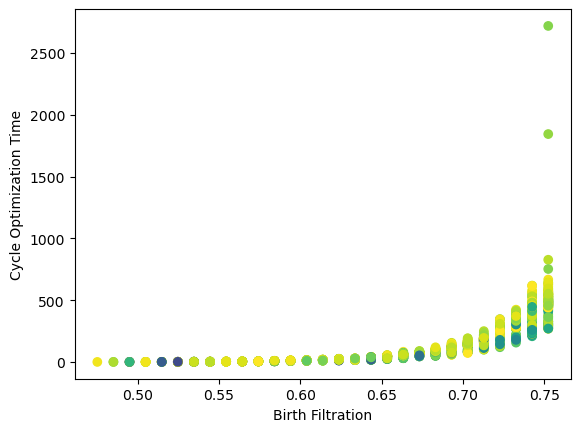

In [5]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Cycle Optimization Time')

ax.scatter(
        glp_optimized['birth'],
        glp_optimized['optimal cycle time'],
        c=glp_optimized['death']
    )

#### Birth vs Time Trend
Fit a log-log regression to the data to estimate how long solving all the cycles would take.

Solved cycles took a total of 192.73 hours, model predicts they'll take 188.06 hours
Model predicts all cycles will take 174789.83 hours (7282.91 days)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:              OLS                Adj. R-squared:     0.985     
Dependent Variable: optimal cycle time AIC:                -1034.4084
Date:               2024-07-02 13:22   BIC:                -1021.6507
No. Observations:   4354               Log-Likelihood:     519.20    
Df Model:           1                  F-statistic:        2.798e+05 
Df Residuals:       4352               Prob (F-statistic): 0.00      
R-squared:          0.985              Scale:              0.046147  
------------------------------------------------------------------------
          Coef.     Std.Err.       t        P>|t|      [0.025     0.975]
------------------------------------------------------------------------
const    11.0614      0.0134    827.8030    0.0000    11.0352    11.0876
birth    17.3561      0.0328    528.9462    0.0000    17.2918    17.4204
---------------------------------------------------------------------
Omnibus:               499.710       Durbin-Watson:          1.496   
Prob(Omnibus):         0.000         Jarque-Bera (JB):       1538.416
Skew:                  -0.597        Prob(JB):               0.000   
Kurtosis:              5.656         Condition No.:          12      
=====================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

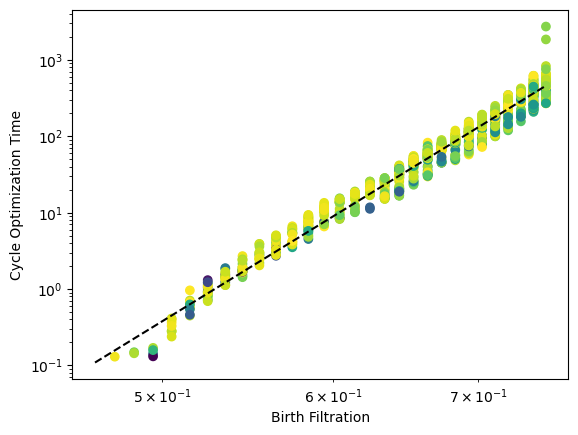

In [6]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Cycle Optimization Time')
ax.set_xscale('log')
ax.set_yscale('log')

reg = sm.OLS(np.log(glp_optimized['optimal cycle time']), sm.add_constant(np.log(glp_optimized['birth']))).fit()

ax.scatter(
        glp_optimized['birth'],
        glp_optimized['optimal cycle time'],
        c=glp_optimized['death']
    )
min_max_birth = np.array([glp_optimized['birth'].min(), glp_optimized['birth'].max()])
ax.plot(
        min_max_birth,
        np.exp(reg.predict(sm.add_constant(np.log(min_max_birth)))),
        'k--'
    )

print(f"Solved cycles took a total of {round(sum(glp_optimized['optimal cycle time']) / 60 / 60, 2)} hours, "
      f"model predicts they'll take {round(sum(np.exp(reg.predict()) / 60 / 60), 2)} hours") # sanity check

total_time = sum(np.exp(reg.predict(sm.add_constant(np.log(homology[homology['dimension'] == 1]['birth']))))) / 60 / 60
print(f"Model predicts all cycles will take {round(total_time, 2)} hours ({round(total_time / 24, 2)} days)") # not good

reg.summary2() # more concise summary

#### Birth vs Number of Rounded Simplicies
For GoodLP, most of the cycles do end up with some bad coefficients that need to be rounded. Later births have more complexity and, therefore, more bad coefficients.

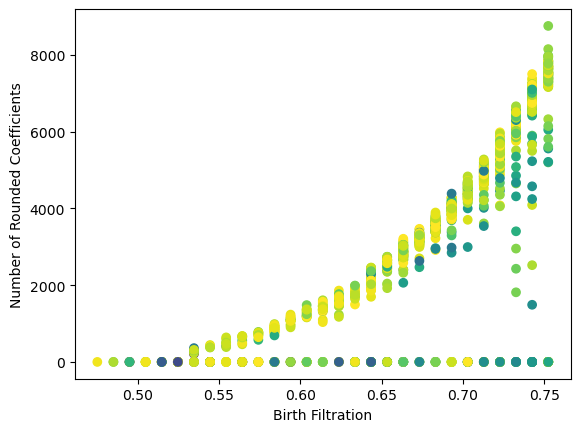

In [7]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Number of Rounded Coefficients')

ax.scatter(
        glp_optimized['birth'],
        glp_optimized['optimal cycle nrz'],
        c=glp_optimized['death']
    )

#### Birth vs Whether or not is is Rounded
Especially at higher filtrations, a significant number of cycles are rounded.

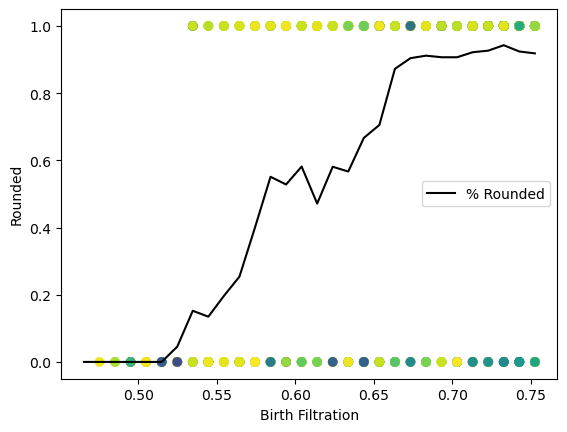

In [8]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Rounded')

grouped = glp_optimized[['birth', 'optimal cycle nrz']].replace(
        0, np.nan
    ).groupby(
        'birth'
    ).agg(
        count=('optimal cycle nrz', 'size'),
        num_rounded=('optimal cycle nrz', 'count')
    ).reset_index()

ax.scatter(
        glp_optimized['birth'],
        1*(glp_optimized['optimal cycle nrz'] > 0),
        c=glp_optimized['death']
    )
ax.plot(grouped['birth'], grouped['num_rounded'] / grouped['count'], 'k-', label='% Rounded')

ax.legend()

#### Errors
Check out optimal cycles that have errors to see what the errors are and why.

In [9]:
err_rows = glp_optimized.index[-glp_optimized['optimal cycle representative'].apply(is_cycle)]
glp_optimized.loc[err_rows]

,id,dimension,birth,death,birth simplex,death simplex,cycle representative,cycle nnz,bounding chain,bounding nnz,optimal cycle representative,optimal cycle nnz,optimal cycle nodes,dirty optimal cycle representative,dirty optimal cycle nnz,optimal cycle nrz,optimal cycle time
1814,39069,1,0.564356,0.970297,"[3667, 8882]","[300, 3193, 9448]",simplex filtration coefficient 0 [...,14,simplex filtration coefficie...,2103.0,"Empty DataFrame Columns: [simplex, filtration,...",0,[],simplex filtration coeffi...,676,676,4.934433
3311,38666,1,0.613861,0.990099,"[2605, 4695]","[1958, 5319, 9042]",simplex filtration coefficient 0 [...,31,simplex filtration coefficie...,3859.0,simplex filtration ...,3,"[implicit function theorem, linear multivariab...",simplex filtration coeff...,1463,1460,18.188393


The first one rounded all the simplicies away. This looks like it's because the optimized coefficients (that shouldn't be rounded) are 1/2 and -1/2, which, following even rounding rules, go to 0.

In [10]:
glp_optimized.loc[err_rows[0], 'dirty optimal cycle representative']

,simplex,filtration,coefficient
0,"[3667, 8882]",0.564356,1/2
1,"[3515, 4703]",0.564356,-1/18167280560098464
2,"[3355, 4604]",0.564356,1/16600394405641558
3,"[2605, 8712]",0.564356,-1/3200241034869536
4,"[2549, 8712]",0.564356,-1/21651037522724536
...,...,...,...
671,"[3150, 5817]",0.366337,-1/2962884538526472
672,"[4956, 5817]",0.346535,0
673,"[5859, 8293]",0.326733,1/10924509786273244
674,"[1753, 7129]",0.168317,1/20605747514568712


The second one also looks like it has something to do with rounding the correct ones away. Specifically, one of the coefficients in the "cleaned" cycle is almost 1/2 and if we change the rounding threshold to 1/4 instead of 1/2, we get a valid cycle.

In [11]:
glp_optimized.loc[err_rows[1], 'optimal cycle representative']

,simplex,filtration,coefficient
567,"[4081, 4695]",0.544554,-1125899906842625/2251799813685249
1364,"[4081, 8069]",0.445545,1125899906842625/2251799813685249
1441,"[4621, 8069]",0.396040,-562949953421313/1125899906842625


In [12]:
dirty_cycle = glp_optimized.loc[err_rows[1], 'dirty optimal cycle representative']
is_cycle(dirty_cycle[np.abs(dirty_cycle['coefficient']) > 0.25])

True

### Gurobi Results
Basic information about cycles solved using Gurobi

#### Number of Cycles Found

In [13]:
f'Found {len(grb_optimized)} cycles of {sum(homology['dimension'] == 1)} ({round(100*len(grb_optimized)/sum(homology['dimension'] == 1), 2)}%)'

'Found 11345 cycles of 36112 (31.42%)'

#### Birth vs Time
Basic visualization of the trend between how long cycles take to optimize and when they're born. The increase is caused by the fact that the LP includes all existing cycles/k+1 dim simplex boundaries in it, and the number of those increases exponentially.

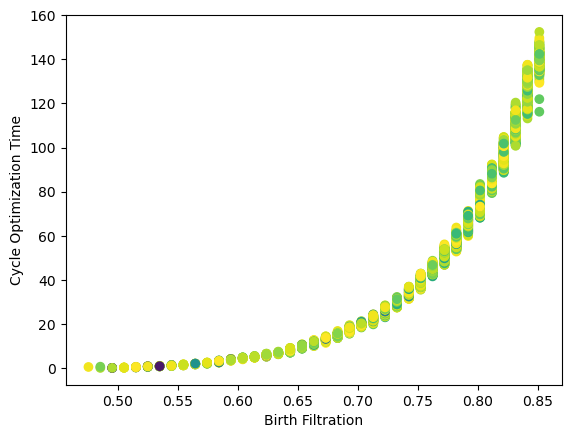

In [14]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Cycle Optimization Time')

ax.scatter(
        grb_optimized['birth'],
        grb_optimized['optimal cycle time'],
        c=grb_optimized['death']
    )

#### Birth vs Time Trend
Fit a log-log regression to the data to estimate how long solving all the cycles would take.

Solved cycles took a total of 192.21 hours, model predicts they'll take 194.37 hours
Model predicts all cycles will take 3057.79 hours (127.41 days)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:              OLS                Adj. R-squared:     0.991      
Dependent Variable: optimal cycle time AIC:                -16728.2205
Date:               2024-07-02 13:22   BIC:                -16713.5474
No. Observations:   11345              Log-Likelihood:     8366.1     
Df Model:           1                  F-statistic:        1.184e+06  
Df Residuals:       11343              Prob (F-statistic): 0.00       
R-squared:          0.991              Scale:              0.013399   
-------------------------------------------------------------------------
          Coef.     Std.Err.        t        P>|t|      [0.025     0.975]
-------------------------------------------------------------------------
const     6.6682      0.0030    2257.4559    0.0000     6.6624     6.6740
birth    10.5890      0.0097    1087.9291    0.0000    10.5699    10.6080
----------------------------------------------------------------------
Omnibus:             14292.387      Durbin-Watson:         0.528      
Prob(Omnibus):       0.000          Jarque-Bera (JB):      3715011.181
Skew:                -6.747         Prob(JB):              0.000      
Kurtosis:            90.618         Condition No.:         10         
======================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

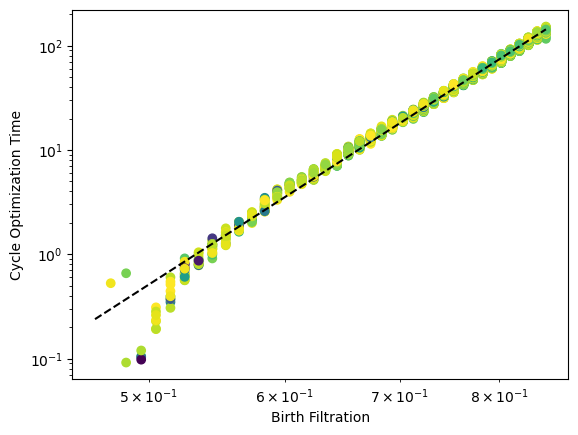

In [15]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Cycle Optimization Time')
ax.set_xscale('log')
ax.set_yscale('log')

reg = sm.OLS(np.log(grb_optimized['optimal cycle time']), sm.add_constant(np.log(grb_optimized['birth']))).fit()

ax.scatter(
        grb_optimized['birth'],
        grb_optimized['optimal cycle time'],
        c=grb_optimized['death']
    )
min_max_birth = np.array([grb_optimized['birth'].min(), grb_optimized['birth'].max()])
ax.plot(
        min_max_birth,
        np.exp(reg.predict(sm.add_constant(np.log(min_max_birth)))),
        'k--'
    )

print(f"Solved cycles took a total of {round(sum(grb_optimized['optimal cycle time']) / 60 / 60, 2)} hours, "
      f"model predicts they'll take {round(sum(np.exp(reg.predict()) / 60 / 60), 2)} hours") # sanity check

total_time = sum(np.exp(reg.predict(sm.add_constant(np.log(homology[homology['dimension'] == 1]['birth']))))) / 60 / 60
print(f"Model predicts all cycles will take {round(total_time, 2)} hours ({round(total_time / 24, 2)} days)")

reg.summary2() # more concise summary

#### Birth vs Number of Rounded Simplicies
For Gurobi, only a few cycles end up with some bad coefficients that need to be rounded. Later births have more complexity and, therefore, more bad coefficients.

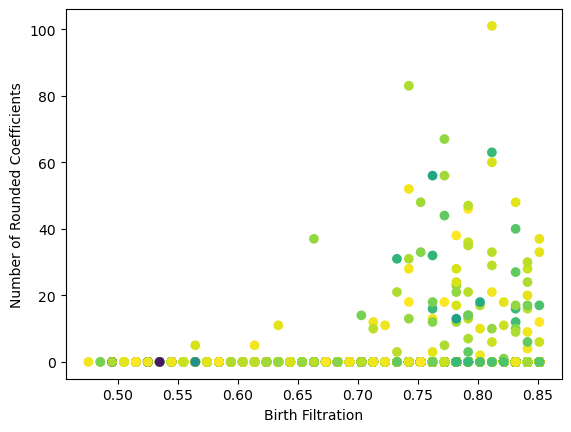

In [16]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Number of Rounded Coefficients')

ax.scatter(
        grb_optimized['birth'],
        grb_optimized['optimal cycle nrz'],
        c=grb_optimized['death']
    )

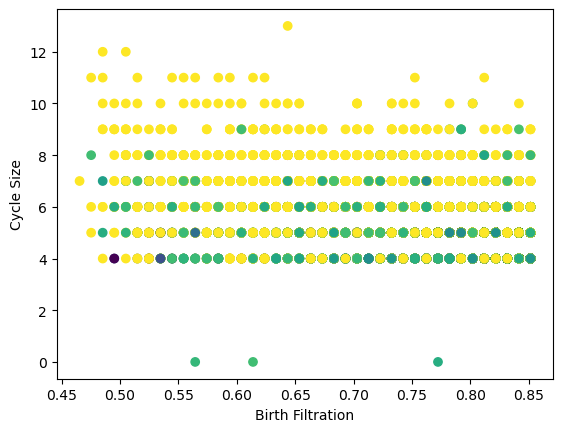

In [37]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Cycle Size')

ax.scatter(
        grb_optimized['birth'],
        grb_optimized['optimal cycle nnz'],
        c=grb_optimized['death'].replace(np.inf, 1.2)
    )

#### Birth vs Whether or not is is Rounded
Across all filtrations, a very small percentage of the cycles are rounded. 

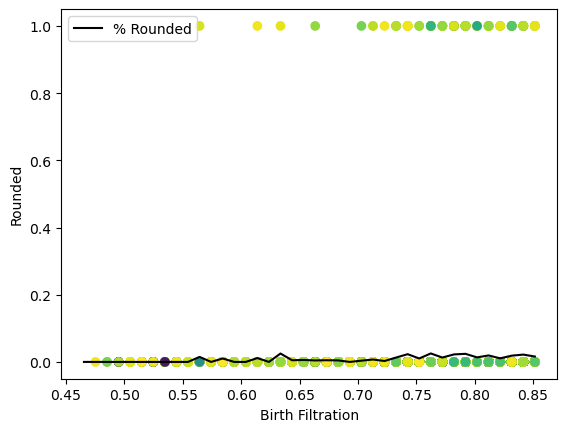

In [17]:
ax = plt.subplot()

ax.set_xlabel('Birth Filtration')
ax.set_ylabel('Rounded')

grouped = grb_optimized[['birth', 'optimal cycle nrz']].replace(
        0, np.nan
    ).groupby(
        'birth'
    ).agg(
        count=('optimal cycle nrz', 'size'),
        num_rounded=('optimal cycle nrz', 'count')
    ).reset_index()

ax.scatter(
        grb_optimized['birth'],
        1*(grb_optimized['optimal cycle nrz'] > 0),
        c=grb_optimized['death']
    )
ax.plot(grouped['birth'], grouped['num_rounded'] / grouped['count'], 'k-', label='% Rounded')

ax.legend()

#### Errors
Check out optimal cycles that have errors to see what the errors are and why.

In [18]:
err_rows = grb_optimized.index[-grb_optimized['optimal cycle representative'].apply(is_cycle)]
grb_optimized.loc[err_rows]

,id,dimension,birth,death,birth simplex,death simplex,cycle representative,cycle nnz,bounding chain,bounding nnz,optimal cycle representative,optimal cycle nnz,optimal cycle nodes,dirty optimal cycle representative,dirty optimal cycle nnz,optimal cycle nrz,optimal cycle time
3762,39069,1,0.564356,0.970297,"[3667, 8882]","[300, 3193, 9448]",simplex filtration coefficient 0 [...,14,simplex filtration coefficie...,2103.0,"Empty DataFrame Columns: [simplex, filtration,...",0,[],simplex filtration coefficient 0 [36...,5,5,1.930917
3798,38666,1,0.613861,0.990099,"[2605, 4695]","[1958, 5319, 9042]",simplex filtration coefficient 0 [...,31,simplex filtration coefficie...,3859.0,"Empty DataFrame Columns: [simplex, filtration,...",0,[],simplex filtration coefficient 0 [26...,5,5,4.692764
6058,34347,1,0.772277,0.940594,"[267, 4083]","[760, 6279, 8926]",simplex filtration coefficient 0 ...,51,simplex filtration coefficien...,169.0,"Empty DataFrame Columns: [simplex, filtration,...",0,[],simplex filtration coefficient 0 [2...,5,5,48.441223


In all three cases, the coefficients were 1/2 instead of 1, and were therefore rounded away in the cleaning process. Again, we could likely change the cleaning threshold and that would avoid the issue.

In [19]:
grb_optimized.loc[err_rows[0], 'dirty optimal cycle representative']

,simplex,filtration,coefficient
0,"[3667, 8882]",0.564356,1/2
1,"[6248, 8882]",0.524752,-1/2
2,"[1168, 6643]",0.514851,1/2
3,"[3667, 6643]",0.495050,-1/2
4,"[1168, 6248]",0.455446,-1/2


In [20]:
grb_optimized.loc[err_rows[1], 'dirty optimal cycle representative']

,simplex,filtration,coefficient
0,"[2605, 4695]",0.613861,1/2
1,"[2605, 4621]",0.564356,-1/2
2,"[4081, 4695]",0.544554,-1/2
3,"[4081, 8069]",0.445545,1/2
4,"[4621, 8069]",0.396040,-1/2


In [21]:
grb_optimized.loc[err_rows[2], 'dirty optimal cycle representative']

,simplex,filtration,coefficient
0,"[267, 4083]",0.772277,1/2
1,"[267, 2836]",0.732673,-1/2
2,"[4083, 4499]",0.653465,1/2
3,"[2836, 7139]",0.653465,-1/2
4,"[4499, 7139]",0.504950,1/2


### Comparison
A look at how the libraries do compared to each other

#### Time
Gurobi is substantially faster for almost 100% of cases

The (almost) vertical dashed line is actually the 45 degree line for reference. Anything right of the line was faster with Gurobi and anything left of the line was faster with GoodLP.

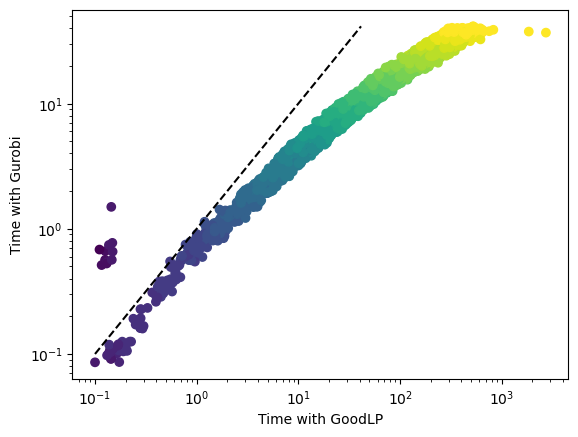

In [38]:
ax = plt.subplot()

ax.set_xlabel('Time with GoodLP')
ax.set_ylabel('Time with Gurobi')
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(
        both_optimized['optimal cycle time_glp'],
        both_optimized['optimal cycle time_grb'],
        c=both_optimized['birth']
    )
min_max = (max(both_optimized['optimal cycle time_grb'].min(), both_optimized['optimal cycle time_glp'].min()),
           min(both_optimized['optimal cycle time_grb'].max(), both_optimized['optimal cycle time_glp'].max()))
ax.plot(
        min_max,
        min_max,
        'k--'
    )

In [23]:
n_faster_with_glp = sum(both_optimized['optimal cycle time_glp'] <= both_optimized['optimal cycle time_grb'])
n_faster_with_grb = sum(both_optimized['optimal cycle time_grb'] <= both_optimized['optimal cycle time_glp'])

f'{n_faster_with_glp} cycles ({round(100 * n_faster_with_glp / len(both_optimized), 2)}%) were optimized faster with GoodLP. ' \
f'{n_faster_with_grb} ({round(100 * n_faster_with_grb / len(both_optimized), 2)}%) were faster with Gurobi'

'12 cycles (0.28%) were optimized faster with GoodLP. 4342 (99.72%) were faster with Gurobi'

#### Different Results
There were 5 cases where the two solvers got different results. One of them, ID 38666, has an error in the cycle that has been discussed in the cycle-specific section.

In [24]:
errors_filter = both_optimized['optimal cycle nnz_glp'] != both_optimized['optimal cycle nnz_grb']
both_optimized[errors_filter]

,id,dimension,birth,death,birth simplex,death simplex,cycle representative,cycle nnz,bounding chain,bounding nnz,...,dirty optimal cycle nnz_grb,optimal cycle nrz_grb,optimal cycle time_grb,optimal cycle representative_glp,optimal cycle nnz_glp,optimal cycle nodes_glp,dirty optimal cycle representative_glp,dirty optimal cycle nnz_glp,optimal cycle nrz_glp,optimal cycle time_glp
862,37177,1,0.693069,inf,"[3782, 5999]",None,simplex filtration coefficient 0 [...,26,None,NaN,...,6,0,18.156770,simplex filtration ...,5,"[good tracking performance, nonminimum phase s...",simplex filtration coeffi...,4058,4053,120.728838
1477,38666,1,0.613861,0.990099,"[2605, 4695]","[1958, 5319, 9042]",simplex filtration coefficient 0 [...,31,simplex filtration coefficie...,3859.0,...,5,5,4.692764,simplex filtration ...,3,"[implicit function theorem, linear multivariab...",simplex filtration coeff...,1463,1460,18.188393
1990,36936,1,0.702970,0.960396,"[3150, 4256]","[3150, 4256, 4772]",simplex filtration coefficient 0 [...,13,simplex filtration coefficie...,1871.0,...,4,0,20.121309,simplex filtration ...,5,"[feedback system, input output system, problem...",simplex filtration coeffi...,4553,4548,150.550667
2027,36493,1,0.722772,0.930693,"[760, 3193]","[267, 3921, 8329]",simplex filtration coefficient 0 ...,19,simplex filtration coefficient...,53.0,...,5,0,24.774175,simplex filtration ...,6,"[runge – kutta scheme, finite difference discr...",simplex filtration coeff...,5129,5123,202.139800
2856,35351,1,0.752475,0.980198,"[238, 8293]","[760, 3019, 6408]",simplex filtration coefficient 0 ...,16,simplex filtration coefficie...,2146.0,...,5,0,36.101553,simplex filtration ...,4,"[galerkin finite element method, steady state ...",simplex filtration coef...,7345,7341,445.184186


For the other 4 that we know don't have errors, they all are valid cycles from both libraries. In half of the cases (IDs 37177 and 35351), GoodLP is smaller and in the other half (IDs 36936 and 36493), Gurobi's is smaller. I don't know what causes this, but it is important to know for both libraries.

In [25]:
pd.DataFrame([
        both_optimized[errors_filter]['id'],
        both_optimized[errors_filter]['optimal cycle nnz_glp'],
        both_optimized[errors_filter]['optimal cycle representative_glp'].apply(is_cycle),
        both_optimized[errors_filter]['optimal cycle nnz_grb'],
        both_optimized[errors_filter]['optimal cycle representative_grb'].apply(is_cycle)
    ]).T.rename(columns={
        'optimal cycle representative_glp': 'is cycle_glp',
        'optimal cycle representative_grb': 'is cycle_grb',
    })

,id,optimal cycle nnz_glp,is cycle_glp,optimal cycle nnz_grb,is cycle_grb
862,37177,5,1,6,1
1477,38666,3,0,0,0
1990,36936,5,1,4,1
2027,36493,6,1,5,1
2856,35351,4,1,5,1
